# IBM Applied Data Science Capstone 
### Popular venues in Alameda County and their relationship to COVID-19 rates

In [1]:
import requests
import json
import math
import pandas as pd
import plotly
from urllib.request import urlopen
import numpy as np
from geopy.geocoders import Nominatim
from IPython.display import Image
from IPython.core.display import HTML
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# Downloading database of COVID-19 rates in Alameda per zip code
url='https://services3.arcgis.com/1iDJcsklY3l3KIjE/arcgis/rest/services/AC_Rates_Zip_Code/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'
alameda_rates=requests.get(url).json()

In [3]:
# Selecting the data of interest
zipcode_data=alameda_rates['features']

In [4]:
zipcode_data[0]

{'attributes': {'Zip': 94501,
  'USPS_City': 'Alameda, CA',
  'Count': '144',
  '1_Jul_2020_Population': 65299.4435044105,
  'Rate_per_100000': '220.522553136726',
  'Popup': '220.5/100,000',
  'Bin': '1',
  'Sort': 220.522553136726,
  'FID': 1}}

In [5]:
# Defining zip_code database from dataset of zip codes and case rates
column_names=['Zip Code','Cases per 100,000 People']
zip_rate= pd.DataFrame(columns=column_names)

In [6]:
# Assigning coordinates to each zip code to use for the FourSquare API call
lat=[]
long=[]
for data in zipcode_data:
    address = data['attributes']['Zip']
    geolocator = Nominatim(user_agent="alameda_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    lat.append(latitude)
    long.append(longitude)

In [7]:
# Filling in the zip_code database 
for data in zipcode_data:
    zip_code=data['attributes']['Zip']
    rate=data['attributes']['Sort']
    zip_rate = zip_rate.append({'Zip Code': zip_code, 'Cases per 100,000 People': rate}, ignore_index=True)

In [8]:
# Adding latitude and longitude columns
zip_rate.insert(2, 'Latitude', lat)
zip_rate.insert(3,'Longitude', long)


In [9]:
zip_rate.dtypes

Zip Code                    float64
Cases per 100,000 People    float64
Latitude                    float64
Longitude                   float64
dtype: object

Zip codes in json files are read as strings so the zip codes in the zip_rate database must be as well

In [10]:
zip_rate['Zip Code']=zip_rate['Zip Code'].astype(int)
zip_rate['Zip Code']=zip_rate['Zip Code'].astype(str)
zip_rate.head()

,Zip Code,"Cases per 100,000 People",Latitude,Longitude
0,94501,220.522553,47.771396,18.101184
1,94502,124.158516,37.735143,-122.241527
2,94505,0.000000,37.891224,-121.616664
3,94514,0.000000,37.861842,-121.626666
4,94536,272.700817,37.560459,-121.973594


In [11]:
# Downloading the GeoJSON file necessary for our choropleth map
with urlopen('https://data.sfgov.org/api/geospatial/u5j3-svi6?method=export&format=GeoJSON') as response:
    zips = json.load(response)

In [12]:
# Finding the coordinates of Castro Valley to center our map there
address = 'Castro Valley, CA, USA'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


In [13]:
# Initialing map of Alameda
map_alameda = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='Mapbox Bright')
# Case rates can't be negative
threshold_scale = np.linspace(zip_rate['Cases per 100,000 People'].min(),
                              zip_rate['Cases per 100,000 People'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist()
threshold_scale[-1] = threshold_scale[-1] + 1

# Defining choropleth
folium.Choropleth(
    geo_data=zips,
    name='choropleth',
    data=zip_rate,
    columns=['Zip Code', 'Cases per 100,000 People'],
    key_on="feature.properties.zip",
    threshold_scale=threshold_scale,
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name="COVID-19 Cases in Alameda County per 100,000 people"
).add_to(map_alameda)

# display map
map_alameda

In [14]:
# The code was removed by Watson Studio for sharing.

In [15]:
# Function to return nearby venues within a 600m radius of each zip code
def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return relevant information for nearby venues
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip Code', 
                  'Zip Code Latitude', 
                  'Zip Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
# Finding popular nearby venues for each zip code
alameda_venues=getNearbyVenues(names=zip_rate['Zip Code'],latitudes=zip_rate.Latitude,longitudes=zip_rate.Longitude)

In [17]:
alameda_venues.head()

,Zip Code,Zip Code Latitude,Zip Code Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,94501,47.771396,18.101184,I Cubed spol. s r.o.,47.769644,18.105871,Home Service
1,94501,47.771396,18.101184,Nástupište 4,47.772500,18.094763,Platform
2,94502,37.735143,-122.241527,La Val's Pizza,37.737610,-122.241001,Italian Restaurant
3,94502,37.735143,-122.241527,La Penca Azul,37.737667,-122.240767,Mexican Restaurant
4,94502,37.735143,-122.241527,Coffee and Tea Traders,37.737493,-122.240265,Coffee Shop


To work with venue categories, we convert categories to numbers using one hot encoding

In [18]:
# one hot encoding
alameda_onehot = pd.get_dummies(alameda_venues[['Venue Category']], prefix="", prefix_sep="")

# adding Zip Code column to dataframe
alameda_onehot['Zip Code'] = alameda_venues['Zip Code'] 

# moving Zip Code column to the first column
fixed_columns = [alameda_onehot.columns[-1]] + list(alameda_onehot.columns[:-1])
alameda_onehot = alameda_onehot[fixed_columns]

alameda_onehot.head()

,Zip Code,ATM,Accessories Store,African Restaurant,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,94501,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,94501,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,94502,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,94502,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,94502,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Grouping venue categories by zip code
alameda_grouped=alameda_onehot.groupby('Zip Code').mean().reset_index()
alameda_grouped.head()

,Zip Code,ATM,Accessories Store,African Restaurant,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Tunnel,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,94501,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,94502,0.066667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,94505,0.000000,0.0,0.0,0.071429,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,94536,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,94538,0.000000,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# List of the top five venue categories and their frequency
num_top_venues = 5

for code in alameda_grouped['Zip Code']:
    print("----"+str(code)+"----")
    temp = alameda_grouped[alameda_grouped['Zip Code'] == code].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----94501----
                  venue  freq
0          Home Service   0.5
1              Platform   0.5
2                   ATM   0.0
3  Other Great Outdoors   0.0
4                 Motel   0.0


----94502----
                venue  freq
0                 ATM  0.07
1      Sandwich Place  0.07
2  Mexican Restaurant  0.07
3       Shopping Mall  0.07
4                Park  0.07


----94505----
                venue  freq
0  Mexican Restaurant  0.14
1         Coffee Shop  0.07
2            Pharmacy  0.07
3       Grocery Store  0.07
4                Bank  0.07


----94536----
                       venue  freq
0  Middle Eastern Restaurant  0.25
1       Gym / Fitness Center  0.25
2                       Lake  0.25
3                       Pool  0.25
4         Italian Restaurant  0.00


----94538----
             venue  freq
0    Grocery Store  0.10
1       Bagel Shop  0.07
2           Bakery  0.07
3   Breakfast Spot  0.03
4  Bubble Tea Shop  0.03


----94541----
                venue  freq
0 

In [21]:
# Function to reverse the order of the venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zip_code_venues_sorted = pd.DataFrame(columns=columns)
zip_code_venues_sorted['Zip Code'] = alameda_grouped['Zip Code']

for ind in np.arange(alameda_grouped.shape[0]):
    zip_code_venues_sorted.iloc[ind, 1:] = return_most_common_venues(alameda_grouped.iloc[ind, :], num_top_venues)
zip_code_venues_sorted.head()

,Zip Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94501,Home Service,Platform,Ethiopian Restaurant,Flower Shop,Flea Market,Fish Market,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Farm
1,94502,ATM,Japanese Restaurant,Playground,Deli / Bodega,Park,Coffee Shop,Sandwich Place,Shipping Store,Shopping Mall,Mexican Restaurant
2,94505,Mexican Restaurant,Cosmetics Shop,Diner,Pharmacy,Sushi Restaurant,Fast Food Restaurant,Tanning Salon,Salon / Barbershop,Bank,Sandwich Place
3,94536,Pool,Lake,Gym / Fitness Center,Middle Eastern Restaurant,Flower Shop,Flea Market,Fish Market,Filipino Restaurant,Fast Food Restaurant,Farmers Market
4,94538,Grocery Store,Bagel Shop,Bakery,Ice Cream Shop,Juice Bar,Breakfast Spot,Sushi Restaurant,Furniture / Home Store,Bubble Tea Shop,Fried Chicken Joint


Now with the most common venues per zip code, we're ready to begin KMeans clustering

In [23]:
kclusters = 3
alameda_grouped_clustering=alameda_grouped.drop('Zip Code',1)
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=12).fit(alameda_grouped_clustering)

In [24]:
# adding clustering labels to database of common venues
zip_code_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
alameda_merged = zip_rate

# merge zip_code_venues_sorted with zip_rate to add latitude/longitude for each neighborhood
alameda_merged = alameda_merged.join(zip_code_venues_sorted.set_index('Zip Code'), on='Zip Code')
alameda_merged = alameda_merged.dropna()
alameda_merged['Cluster Labels'] = alameda_merged['Cluster Labels'].astype(int)
alameda_merged.head()

,Zip Code,"Cases per 100,000 People",Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94501,220.522553,47.771396,18.101184,0,Home Service,Platform,Ethiopian Restaurant,Flower Shop,Flea Market,Fish Market,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Farm
1,94502,124.158516,37.735143,-122.241527,0,ATM,Japanese Restaurant,Playground,Deli / Bodega,Park,Coffee Shop,Sandwich Place,Shipping Store,Shopping Mall,Mexican Restaurant
2,94505,0.000000,37.891224,-121.616664,0,Mexican Restaurant,Cosmetics Shop,Diner,Pharmacy,Sushi Restaurant,Fast Food Restaurant,Tanning Salon,Salon / Barbershop,Bank,Sandwich Place
4,94536,272.700817,37.560459,-121.973594,0,Pool,Lake,Gym / Fitness Center,Middle Eastern Restaurant,Flower Shop,Flea Market,Fish Market,Filipino Restaurant,Fast Food Restaurant,Farmers Market
5,94538,356.310944,37.548069,-121.989273,0,Grocery Store,Bagel Shop,Bakery,Ice Cream Shop,Juice Bar,Breakfast Spot,Sushi Restaurant,Furniture / Home Store,Bubble Tea Shop,Fried Chicken Joint


In [41]:
# initializing cluster map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# cluster color scheme
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# map markers
markers_colors = []

for lat, lon, poi, cluster in zip(alameda_merged['Latitude'], alameda_merged['Longitude'], alameda_merged['Zip Code'], alameda_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],radius=5,popup=label,color='black',fill=True,fill_color=rainbow[int(cluster)-1],fill_opacity=0.7).add_to(map_clusters)
    
map_clusters.save('clusters.html')

Combining the choropleth and cluster maps to visualize trends

In [26]:
# initializing map
map_alameda = folium.Map(location=[latitude, longitude], zoom_start=11, tiles='Mapbox Bright')

# Case rates can't be negative
threshold_scale = np.linspace(zip_rate['Cases per 100,000 People'].min(),
                              zip_rate['Cases per 100,000 People'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist()
threshold_scale[-1] = threshold_scale[-1] + 1

# Defining choropleth layer
folium.Choropleth(
    geo_data=zips,
    name='choropleth',
    data=zip_rate,
    columns=['Zip Code', 'Cases per 100,000 People'],
    key_on="feature.properties.zip",
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name="COVID-19 Cases in Alameda County per 100,000 people"
).add_to(map_alameda)

# cluster color scheme
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []

# Defining cluster layer
for lat, lon, poi, cluster in zip(alameda_merged['Latitude'], alameda_merged['Longitude'], alameda_merged['Zip Code'], alameda_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon],radius=5,popup=label,color='black',fill=True,fill_color=rainbow[int(cluster)-1],fill_opacity=0.7).add_to(map_alameda)

map_alameda

In [27]:
# Creating database of case rates per cluster
c0 = alameda_merged.loc[alameda_merged['Cluster Labels'] == 0, alameda_merged.columns[[1]]]
c0 = c0['Cases per 100,000 People']
c0 = pd.Series(c0)
c1 = alameda_merged.loc[alameda_merged['Cluster Labels'] == 1, alameda_merged.columns[[1]]].reset_index()
c1 = c1['Cases per 100,000 People']
c1 = pd.Series(c1)
c2 = alameda_merged.loc[alameda_merged['Cluster Labels'] == 2, alameda_merged.columns[[1]]].reset_index()
c2 = c2['Cases per 100,000 People']
c2 = pd.Series(c2)
c3 = alameda_merged.loc[alameda_merged['Cluster Labels'] == 3, alameda_merged.columns[[1]]].reset_index()
c3 = c3['Cases per 100,000 People']
c3 = pd.Series(c3)

box_data= pd.DataFrame({'Cluster 0': c0, 'Cluster 1': c1, 'Cluster 2':c2})
box_data.head(10)

,Cluster 0,Cluster 1,Cluster 2
0,220.522553,609.639027,660.303465
1,124.158516,2020.219730,0.000000
2,0.000000,NaN,128.691398
3,NaN,NaN,119.012236
4,272.700817,NaN,NaN
5,356.310944,NaN,NaN
7,955.619737,NaN,NaN
11,503.159179,NaN,NaN
12,425.736249,NaN,NaN
13,518.426668,NaN,NaN


Box plots allow for easy visualization of case rates between clusters

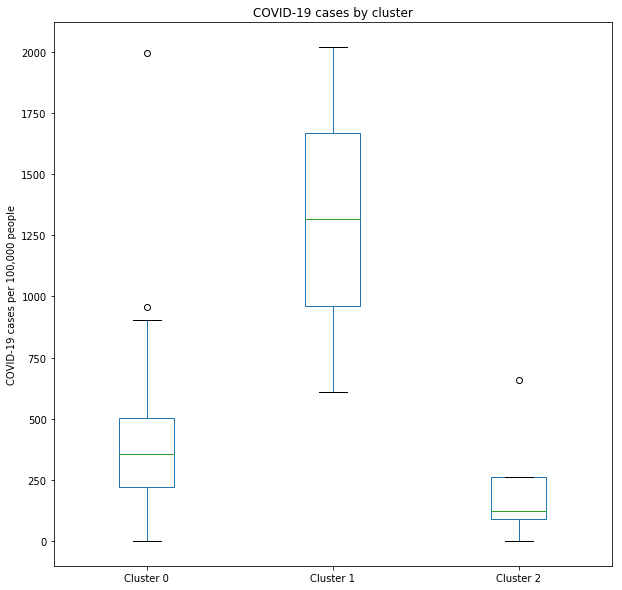

In [36]:
box_data.plot(kind='box', figsize=(10, 10))
plt.title('COVID-19 cases by cluster')
plt.ylabel('COVID-19 cases per 100,000 people')

plt.savefig('box.jpg')

In [39]:
# Most common venues for each of the zip codes in Cluster 0
cluster_0 = alameda_merged.loc[alameda_merged['Cluster Labels'] == 0, alameda_merged.columns[[0] + [1] + list(range(5, alameda_merged.shape[1]))]]
cluster_0.shape

(41, 12)

In [38]:
# Most common venues for each of the zip codes in Cluster 1
cluster_1 = alameda_merged.loc[alameda_merged['Cluster Labels'] == 1, alameda_merged.columns[[0] + [1] + list(range(5, alameda_merged.shape[1]))]]
cluster_1.shape

(2, 12)

In [37]:
# Most common venues for each of the zip codes in Cluster 2
cluster_2 = alameda_merged.loc[alameda_merged['Cluster Labels'] == 2, alameda_merged.columns[[0] + [1] + list(range(5, alameda_merged.shape[1]))]]
cluster_2.shape

(4, 12)